In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-disease-classification-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2999773%2F5162051%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T051238Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2998893806a1e613132403135d22744f34909ce3667d4b6bb8b26380138bd115c89dd4b887e8cf98cf9529d05533be15ccdfcb0e4c527e3e12701b1a9a233b01a5106024534708827122bc85c6bcdb1c04843f8d974568d53c52595ced4312383fd01bc7a4cf38f118656ee77e8edb8dd62ff5994167812507c9a14c3d0299b6148fb65b5bc180423d7e8db855282736af320021d9568e88598b6cc78296fd7ba58c9a2c2fa4bc55cf81f283f04bb97f5ebc90f0024125a70f9dd3a087a8bff3d414d2429620c1a41b3ede1bad929aa54ab6eb52b9731c2ac1a2663f9b7fa316d6af6b5577244bbe2c85471b70bc64d5e23e71c4c84a0222439ad8bfb5cd5c58,mobilenet-v1/tensorflow1/100-224-quantops-feature-vector/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F1621%2F2021%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T051238Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72580198a325b91473cb0cc5e0a6e8cdf08f8f01e111a8ff447f62f3fa2529dec02bfe287b27b5f09ebb3eb86cc00c717aa209a8ac44b53b783756e0101c93715a2eb4b96943887c237d17ba3e5428064ebbd05bf44c9695b1749e141487aec350e2ef8ea0b49a58dd3299aa08052bed7d4109fc2bc46c552226d2c37a43c035e5f2e11c0d45b249970692a7adcbeeaddafeaf0a3aa265f21f753cb7b1a3238bdb6e6c6ee5db9ba7ac1c7ea257e864180b03b9e4ce99b57166a79806290166409816ecb55f1069973f205ef1c1ba9691a9a18ea387345ed3bb93c44eaadd7ca49d79ced4d9c8da0b0e1367a85273a985351e5a7969158e35b1901d091f64525e,densenet/tflite/default/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F2342%2F3131%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T051238Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f5f2b0a1e6fe83b65232201db1982ec39fe3b60e98c0e7946656677df2b92cc3c814be5b298ce35c6807e0b32ead34503089c5c823f75cc058684728fbfc6f3e6494d18d011d3116338a86547715b7aca082d30d17a259073b09353189e1c764c24f7a73b96adf653572793be2fea6614113532c7d5ad15535d79a0c3aaf0c098d99bf6471a4550c93b7afec1175f19659bb53e4c772eab1f1e4f45aade87cdc8d858ae8b4c08ec75b5e1918e717100d34b66dcc9df082a57b1565767a5043fdddd40c7583dc3fad5e24ae21e4a0ba35c494712269b862158f9e002a82affd7f9894166c16729a1d174351e38f6a612e2cef1188b68c5c0a5b01374acdde09c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


OSError: [WinError 1314] A required privilege is not held by the client: '/kaggle/input' -> '..\\input'

# Skin Disease classification using CNN Algorithm

# Import Libraries

In [4]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os

In [5]:
IMG_SAVE_PATH = r'/kaggle/input/skin-disease-classification-image-dataset/Split_smol/train'

In [6]:
Str_to_Int = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma':5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis':7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9


def str_to_Int_mapper(val):
    return Str_to_Int[val]

# Data Preprocessing


In [7]:
import PIL
import cv2

dataset = []
for directory in os.listdir(IMG_SAVE_PATH):
    path = os.path.join(IMG_SAVE_PATH, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath=PIL.Image.open(new_path)
            #if imgpath.shape!=(240,240,3):
            imgpath=imgpath.convert('RGB')
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240,240))
            img=img/255.
            dataset.append([img, directory])
        except FileNotFoundError:
            print('Image file not found. Skipping...')

In [8]:
data, labels = zip(*dataset)
temp = list(map(str_to_Int_mapper, labels))

In [9]:
data[0]

array([[[0.95686275, 0.85098039, 0.81960784],
        [0.95686275, 0.85098039, 0.81960784],
        [0.95686275, 0.85098039, 0.81960784],
        ...,
        [0.94901961, 0.83529412, 0.78823529],
        [0.94901961, 0.83529412, 0.78823529],
        [0.94901961, 0.83529412, 0.78823529]],

       [[0.95686275, 0.85098039, 0.81960784],
        [0.95686275, 0.85098039, 0.81960784],
        [0.95686275, 0.85098039, 0.81960784],
        ...,
        [0.94509804, 0.82745098, 0.78431373],
        [0.94117647, 0.82745098, 0.78431373],
        [0.94117647, 0.82745098, 0.78431373]],

       [[0.95686275, 0.85490196, 0.82352941],
        [0.95686275, 0.85490196, 0.82352941],
        [0.95686275, 0.85490196, 0.81960784],
        ...,
        [0.93333333, 0.81960784, 0.77647059],
        [0.93333333, 0.81960784, 0.77647059],
        [0.93333333, 0.81960784, 0.77647059]],

       ...,

       [[0.79607843, 0.69803922, 0.65882353],
        [0.79607843, 0.69803922, 0.65882353],
        [0.79607843, 0

In [10]:
import keras
labels = keras.utils.to_categorical(temp)

In [11]:
count=0
for i in data:
    if i.shape!=(240, 240, 3):
        count=count+1
print(count)

0


# CNN

In [12]:
def cnn():
    model=Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(240,240,3)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))

    return model

In [13]:
from keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten
model_cnn=cnn()
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),         # lr = learning_rate
    loss='categorical_crossentropy',   # Multi-class classification
    metrics=['accuracy']
)

In [14]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 118, 118, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 32)        0         
 g2D)                                                   

In [16]:
history_cnn=model_cnn.fit(np.array(data), np.array(labels), epochs = 50, shuffle = True, validation_split = 0.25)

Epoch 1/50
17/17 [==============================] - 2s 97ms/step - loss: 1.9429 - accuracy: 0.2433 - val_loss: 2.5859 - val_accuracy: 0.0229
Epoch 2/50
17/17 [==============================] - 1s 70ms/step - loss: 1.8840 - accuracy: 0.2433 - val_loss: 2.7112 - val_accuracy: 0.0286
Epoch 3/50
17/17 [==============================] - 1s 69ms/step - loss: 1.8241 - accuracy: 0.2644 - val_loss: 2.6761 - val_accuracy: 0.0400
Epoch 4/50
17/17 [==============================] - 1s 68ms/step - loss: 1.7528 - accuracy: 0.3295 - val_loss: 2.7359 - val_accuracy: 0.0400
Epoch 5/50
17/17 [==============================] - 1s 72ms/step - loss: 1.7904 - accuracy: 0.3027 - val_loss: 2.6537 - val_accuracy: 0.0343
Epoch 6/50
17/17 [==============================] - 1s 72ms/step - loss: 1.7395 - accuracy: 0.3180 - val_loss: 2.7692 - val_accuracy: 0.0400
Epoch 7/50
17/17 [==============================] - 1s 77ms/step - loss: 1.6963 - accuracy: 0.3391 - val_loss: 2.9211 - val_accuracy: 0.0400
Epoch 8/50
17

# Save model

In [17]:
# save the model for later use
model_cnn.save("skin_disease_model_ISIC_densenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate Models

In [18]:
IMG_SAVE_PATH_TESTING = r'/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val'

In [19]:
import PIL
import cv2
dataset_testing = []
for directory in os.listdir(IMG_SAVE_PATH_TESTING):
    path = os.path.join(IMG_SAVE_PATH_TESTING, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        imgpath=PIL.Image.open(new_path)
        #if imgpath.shape!=(240,240,3):
        imgpath=imgpath.convert('RGB')
        img = np.asarray(imgpath)
#         img = cv2.imread(new_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (240, 240))
        img=img/255.
        dataset_testing.append([img, directory])

In [20]:
testing_data, testing_labels = zip(*dataset_testing)
testing_temp = list(map(str_to_Int_mapper, testing_labels))

In [21]:
import keras
testing_labels = keras.utils.to_categorical(testing_temp)

In [22]:
model_cnn.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 [==============================] - 1s 115ms/step - loss: 1.9817 - accuracy: 0.4862


[1.9817255735397339, 0.4861878454685211]

In [26]:
pip install scikit-plot

# Prediction

In [27]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot

# Make predictions
def make_preds(model):
    label_preds = model.predict(np.array(testing_data))

    def one_hot_highest(arr):
        for row in arr:
            max_val = max(row)
            for i in range(len(row)):
                if row[i] == max_val:
                    row[i] = 1
                else:
                    row[i] = 0
        return arr

    arr=one_hot_highest(label_preds) #one hot
    arr2= one_hot_highest(testing_labels)

    labelenc=[]
    for i in range (0, len(arr)):
        flag=0
        for j in range (0,9):
            if arr[i][j]==1:
                labelenc.append(j)
                flag=1
    labelenctest=[]
    for i in range (0, len(arr2)):
        for j in range (0,9):
            if arr2[i][j]==1:
                labelenctest.append(j)

    scikitplot.metrics.plot_confusion_matrix(labelenctest,labelenc)

6/6 [==============================] - 0s 22ms/step


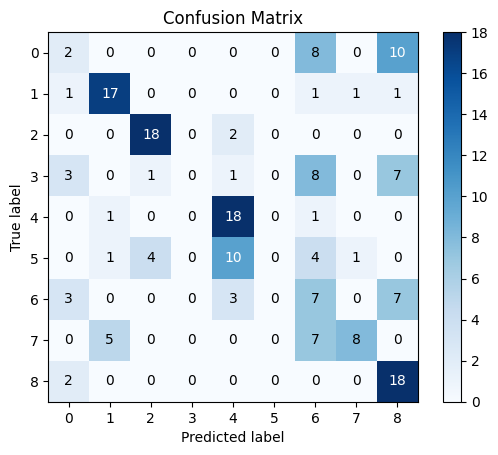

In [28]:
make_preds(model_cnn)

In [30]:
import numpy as np
import os
import cv2
from keras.models import load_model
from keras.preprocessing import image

# Load the saved model
model = load_model("/content/skin_disease_model_ISIC_densenet.h5")

# Define the mapping from class index to class name
Int_to_Str = {
    0: 'Actinic keratosis',
    1: 'Atopic Dermatitis',
    2: 'Benign keratosis',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevus',
    5: 'Melanoma',
    6: 'Squamous cell carcinoma',
    7: 'Tinea Ringworm Candidiasis',
    8: 'Vascular lesion'
}

# Function to preprocess a single image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(240, 240))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Directory containing test images
test_dir = r'/content/TEST'

# List to store predictions
predictions = []

# Iterate over test images
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    if os.path.isfile(img_path):
        # Preprocess the image
        img = preprocess_image(img_path)
        # Get the model's prediction
        pred = model.predict(img)
        # Get the class index with the highest probability
        pred_class_index = np.argmax(pred)
        # Map the class index to class name
        pred_class = Int_to_Str[pred_class_index]
        # Append the prediction to the list
        predictions.append((img_file, pred_class))

# Print predictions
for img_file, pred_class in predictions:
    print(f"Image: {img_file}, Predicted class: {pred_class}")


1/1 [==============================] - 0s 77ms/step
Image: download.jpg, Predicted class: Atopic Dermatitis


In [2]:
# Define a mapping of skin diseases to suggestions
skin_disease_suggestions = {
    'Actinic keratosis': "Actinic keratosis is often treated with cryotherapy or topical medications. It's important to protect your skin from sun exposure.",
    'Atopic Dermatitis': "Atopic dermatitis, or eczema, can be managed with moisturizers, corticosteroids, and avoiding triggers like certain soaps or fabrics.",
    'Benign keratosis': "Benign keratosis, such as seborrheic keratosis, usually doesn't require treatment unless for cosmetic reasons. Consult a dermatologist for evaluation.",
    'Dermatofibroma': "Dermatofibroma is usually harmless but can be removed if it causes discomfort. Consult a dermatologist for evaluation and treatment options.",
    'Melanocytic nevus': "Melanocytic nevus, commonly known as a mole, should be monitored for changes in size, shape, or color. Consult a dermatologist if you notice any changes.",
    'Melanoma': "Melanoma is a serious type of skin cancer. Early detection and treatment are crucial. Consult a dermatologist immediately if you notice any suspicious moles or lesions.",
    'Squamous cell carcinoma': "Squamous cell carcinoma is a type of skin cancer that usually appears as a firm, red nodule or a flat lesion with a scaly crust. Consult a dermatologist for diagnosis and treatment.",
    'Tinea Ringworm Candidiasis': "Tinea, ringworm, and candidiasis are fungal skin infections that can be treated with antifungal medications. Keep the affected area clean and dry.",
    'Vascular lesion': "Vascular lesions, such as hemangiomas or port-wine stains, are usually harmless but can be removed for cosmetic reasons. Consult a dermatologist for evaluation and treatment options."
    # Add suggestions for other skin diseases as needed
}

# Assuming you have trained your skin disease model and made predictions stored in 'predicted_disease'
predicted_disease = "Atopic Dermatitis"  # Example predicted disease

# Retrieve suggestions based on the predicted disease
if predicted_disease in skin_disease_suggestions:
    suggestions = skin_disease_suggestions[predicted_disease]
else:
    suggestions = "No specific suggestions available for the predicted skin disease."

# Print or present suggestions to the user
print("Suggestions for", predicted_disease, ":", suggestions)


Suggestions for Atopic Dermatitis : Atopic dermatitis, or eczema, can be managed with moisturizers, corticosteroids, and avoiding triggers like certain soaps or fabrics.
